In [152]:
from keras.layers import *
from keras.models import *
from keras import backend as B
from keras.activations import *
from keras.optimizers import *
from keras.losses import *
from keras.utils import to_categorical
import numpy as np
from utils import BoundBox, bbox_iou
import xml.etree.ElementTree as ET
from keras.callbacks import EarlyStopping, ModelCheckpoint
import skimage.io as io
import skimage.transform as trans
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
IMAGE_H, IMAGE_W = IMG_H, IMG_W
BOX              = 5
CLASS            = len(Labels)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS=[2.68577038, 3.95905011, 6.16050469, 9.7995892,  3.20700188, 6.77355498,5.54344952, 5.31195913, 2.07246169, 2.22253352]
# ANCHORS=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0
BATCH_SIZE       = 20
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 5
# wt_path = 'yolov2.weights'                      

In [154]:
Labels=['face']
IMG_W=416
IMG_H=416
GRID_H,  GRID_W  = 13 , 13
L=LabelEncoder()
enc_labels=L.fit_transform(Labels)

In [155]:
IMG_DIR=r'C:/Users/MuhammadUsman/Desktop/Data/Widerface_subset/imgs1'
ANN_DIR=r'C:/Users/MuhammadUsman/Desktop/Data/Widerface_subset/xmls'

In [158]:
def load_data(ANN_DIR,IMG_DIR,labels,label_encoder,Max_boxes,IMG_W,IMG_H):
    xmls=os.listdir(ANN_DIR)
    ext=os.listdir(IMG_DIR)[0][-4:]
    all_imgs=[]
    for count,file_ in enumerate(xmls[:20]):
        B_Boxes=[]#np.zeros((Max_boxes,5),dtype=float)
        print (count)
        img={}
        tree=ET.parse(os.path.join(ANN_DIR,file_))
        obj_count=-1
        B_Boxes=np.zeros((Max_boxes,5))
        for elem in tree.iter():
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj_count+=1
                for attr in list(elem):
                    if 'name' in attr.tag:
                        name=attr.text
                        if name not in labels:
                            break
                        else:
                            B_Boxes[obj_count][4]=label_encoder.transform([name])[0]
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                 B_Boxes[obj_count][0]= round(float(dim.text))
                            if 'ymin' in dim.tag:
                                B_Boxes[obj_count][1] = round(float(dim.text))
                            if 'xmax' in dim.tag:
                                B_Boxes[obj_count][2] = round(float(dim.text))
                            if 'ymax' in dim.tag:
                                B_Boxes[obj_count][3] = round(float(dim.text))
        unr_im=io.imread(os.path.join(IMG_DIR,file_[:-4])+ext)
        im=trans.resize(unr_im,(IMG_W,IMG_H,3))
        B_Boxes=np.array(B_Boxes)
        B_Boxes[:,[0,2]]=(B_Boxes[:,[0,2]]*IMG_W/unr_im.shape[1]).astype(int)
        B_Boxes[:,[1,3]]=(B_Boxes[:,[1,3]]*IMG_H/unr_im.shape[0]).astype(int)
        img['boxes']=B_Boxes
        img['img']=im
        img['obj_count']=obj_count
        if obj_count> -1:
            all_imgs += [img]                
    return all_imgs

In [159]:
Data=load_data(ANN_DIR,IMG_DIR,Labels,L,TRUE_BOX_BUFFER,IMG_W,IMG_H)

0
1
2


C:\ProgramData\Anaconda2\envs\py3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [160]:
anchors=[BoundBox(0, 0,ANCHORS[i*2],ANCHORS[i*2+1],) for i in range(int(len(ANCHORS)//2))]
len(anchors)

5

In [161]:
def format_data(Data):
    x_batch=[]
    b_batch=[]
    batch_size=len(Data)
    objects=[]
    for i in Data:
        x_batch.append(i['img'])
        b_batch.append(i['boxes'][:,:4])
        objects.extend(i['boxes'][:,4])
    objecs=np.array(objects).reshape(-1,1)
    c=np.array(b_batch)
    b=np.empty(c.shape)
    b[:,:,0]=((c[...,0]+c[...,2])/2.0/(IMG_W/GRID_W))
    b[:,:,1]=((c[...,1]+c[...,3])/2.0/(IMG_H/GRID_H))
    grid_x=b[...,0].astype(int)
    grid_y=b[...,1].astype(int)
    inc=np.sum(c,axis=2)!=0
#     print (grid_x.flatten())
    grid_x[inc]+=1
    grid_y[inc]+=1
    b[...,2]=(c[...,2]-c[...,0])/(IMG_W/GRID_W)
    b[...,3]=(c[...,3]-c[...,1])/(IMG_H/GRID_H)
    print (b.shape)
    y_batch=np.zeros(shape=(c.shape[0],GRID_H+1,GRID_W+1,c.shape[1],4+1+len(Labels)),dtype=np.float32)
    idx=((np.ones(grid_x.shape,dtype=int).T*np.arange(grid_x.shape[0],dtype=int)).T).flatten()
    assigned_anchors=np.ones((b.shape[0],b.shape[1]),dtype=np.int16)*-1
    for img in range(b.shape[0]):
        for obj in range(b.shape[1]):
            current_box=BoundBox(0,0,b[img,obj,2],b[img,obj,3])
            iou_=np.zeros(len(anchors))
            for j in range(len(anchors)):
                iou_[j]=bbox_iou(current_box,anchors[j])
            assigned_anchors[img,obj]=np.argmax(iou_)
    tensor=np.c_[b.reshape(-1,4),np.ones((b.shape[0]*b.shape[1],1)),objects]
#     print (tensor)
#     print (idx)
#     print (grid_x.flatten())
#     print (grid_y.flatten())
#     print (assigned_anchors.flatten())
    y_batch[idx,grid_y.flatten(),grid_x.flatten(),assigned_anchors.flatten()]=tensor
    y_batch=y_batch[:,1:,1:,:,:]
    return np.array(x_batch),b.reshape(-1,1,1,1,b.shape[1],b.shape[2]),y_batch
x_batch, b_batch,y_batch=format_data(Data)

(20, 5, 4)


In [162]:
print (x_batch.shape)
print (b_batch.shape)
print (y_batch.shape)

(20, 416, 416, 3)
(20, 1, 1, 1, 5, 4)
(20, 13, 13, 5, 6)


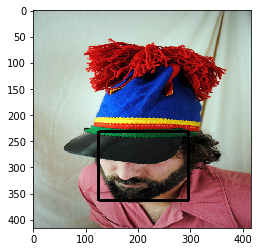

In [163]:
i=np.random.randint(0,len(Data))
val=Data[i]
img=val['img']
for box in val['boxes']:
    box=box.astype(int)
    img=cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]), (0,0,0), 3)
plt.imshow(img)

In [164]:
class MobileNetV2:
    def __init__(self,input_shape,output_shape):
        self.input_shape=input_shape
        self.classes=output_shape
        self.model,self.input_layer=self.make_model()
#         self.loss()
    def expansion_layer(self,input_,expansion_factor):
        inp_channels=B.int_shape(input_)[-1]
        x=Conv2D(inp_channels*expansion_factor,(1,1),strides=(1,1),padding='same') (input_)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
#         x=relu(x)
        return x
    def inverted_residual_block(self,input_,expansion_factor,output_channels,kernel,stride,flag):
        x=self.expansion_layer(input_,expansion_factor)
        x=DepthwiseConv2D(kernel,stride,padding='same')(x)
        x=BatchNormalization()(x)
        x=Activation('relu')(x)
#         x=relu(x)
        x=Conv2D(output_channels,(1,1),strides=(1,1),padding='same')(x)
        x=BatchNormalization()(x)
        if (flag):
            x=add([input_,x])
        return x
    def n_inverted_residual_blocks(self,input_,expansion_factor,output_channels,kernel,stride,n):
        x=self.inverted_residual_block(input_,expansion_factor,output_channels,kernel,stride,False)
        for i in range(n-1):
            x=self.inverted_residual_block(x,expansion_factor,output_channels,kernel,(1,1),True)
        return x
    def make_model(self):
        input_=Input(self.input_shape)
        x=Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same')(input_)
        x=self.n_inverted_residual_blocks(x,1,16,(3,3),(1,1),1)
        x=self.n_inverted_residual_blocks(x,6,24,(3,3),(2,2),2)
        x=self.n_inverted_residual_blocks(x,6,32,(3,3),(2,2),3)
        x=self.n_inverted_residual_blocks(x,6,64,(3,3),(2,2),4)
        x=self.n_inverted_residual_blocks(x,6,96,(3,3),(1,1),3)
        x=self.n_inverted_residual_blocks(x,6,160,(3,3),(2,2),3)
        x=self.n_inverted_residual_blocks(x,6,320,(3,3),(1,1),1)
        return x,input_
#         return Model(input_, x)
    def loss(self):
        self.model.compile('adam', loss=categorical_crossentropy,metrics=['accuracy'])
    def fit(self,X,y,batch_size):
        self.model.fit(X,y,n,batch_size)

In [165]:
B.clear_session()
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
model=MobileNetV2((416,416,3),10)
input_image=model.input_layer
x=model.model
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

In [166]:
model = Model([input_image, true_boxes], output)

In [167]:
def custom_loss(y_true, y_pred):
#     print (y_true.shape)
    mask_shape = tf.shape(y_true)[:4]
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_y,cell_x], -1), [BATCH_SIZE, 1, 1, 5, 1])
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically 
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half        
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    true_box_conf = iou_scores * y_true[..., 4]
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)   
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE  
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half     
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)   
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, tf.ones_like(coord_mask)],lambda: [true_box_xy, true_box_wh,coord_mask])
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    loss = loss_xy + loss_wh + loss_conf + loss_class
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 
    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    return loss

In [168]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, mode='min',verbose=1)
checkpoint = ModelCheckpoint('weights_coco.h5',monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
optimizer = Adam(lr=0.5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=custom_loss, optimizer=optimizer)

In [169]:
print (true_boxes)

Tensor("input_1:0", shape=(?, 1, 1, 1, 5, 4), dtype=float32)


In [170]:
print(y_batch.shape)

(20, 13, 13, 5, 6)


In [171]:
model.fit(x=[x_batch, b_batch],y=y_batch,batch_size=BATCH_SIZE)

Epoch 1/1
20/20 [==============================] - 120s 6s/step - loss: 243.4043
